In [3]:
import SOAPify.HDF5er as HDF5er
from SOAPify import (
    saponifyTrajectory,
    fillSOAPVectorFromdscribe,
    normalizeArray,
    getSOAPSettings,
)
from SOAPify.analysis import timeSOAPsimple
import h5py
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.patches import Circle
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.signal import savgol_filter
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import numpy as np
from multiprocessing.pool import ThreadPool as Pool
from seaborn import kdeplot
import dscribe

SOAPrcut = 25 # Ångström (Distance for pi-pi stacking)
SOAPnmax = 8
SOAPlmax = 8


In [19]:
%%bash
module load plumed/2.7.1
module load gromacs/2021
mkdir -p ../SOAP
name=motor2m_frac2-90
gmx make_ndx -f ../trajectories/${name}/${name}.pdb -n ../trajectories/${name}/${name}.ndx -o ../SOAP/core.ndx << EOF
a C3 C5 C6 C10 C13 C16 C24 C27 S1 S2
name 12 MM2_red
q

EOF
gmx check -f ../trajectories/${name}/${name}.xtc
echo 12 | gmx trjconv -f ../trajectories/${name}/${name}.xtc -s ../trajectories/${name}/${name}.pdb -o ../SOAP/cores.xtc -n ../SOAP/core.ndx -dt 1000
echo 12 | gmx trjconv -f ../trajectories/${name}/${name}.xtc -s ../trajectories/${name}/${name}.pdb -o ../SOAP/cores.gro -n ../SOAP/core.ndx -e 0

printf "[CENTRAL_ATOMS]\n" > ../SOAP/central_atoms.ndx
grep -o 'C6\s\+[0-9]\+' ../SOAP/cores.gro | awk '{print $2}' >> ../SOAP/central_atoms.ndx

rm ../SOAP/\#*
rm ../SOAP/CG-fibr*.hdf5
SOAPify-prepareTrajectory ../SOAP/cores.gro ../SOAP/fibre.hdf5 -t ../SOAP/cores.xtc -u atom_style "all"

                 :-) GROMACS - gmx make_ndx, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            Teem

Going to read 1 old index file(s)

  0 System              : 30800 atoms
  1 Other               : 30400 atoms
  2 MOTOR               : 30400 atoms
  3 motorB              : 27360 atoms
  4 motor2m             :  3040 atoms
  5 iso-R               : 15200 atoms
  6 iso-S               : 15200 atoms
  7 HED                 :  6800 atoms
  8 RLG                 :  6000 atoms
  9 LLG                 :  6000 atoms
 10 COR                 : 11600 atoms
 11 NA                  :   400 atoms

 nr : group      '!': not  'name' nr name   'splitch' nr    Enter: list groups
 'a': atom       '&': and  'del' nr         'splitres' nr   'l': list residues
 't': atom type  '|': or   'keep' nr        'splitat' nr    'h': help
 'r': residue              'res' nr         'chain' char
 "name": group             'case': case sensitive           'q': save and quit
 'ri': residue index

> 
Found 2000 atoms with names C3 C5 C6 C10 C13 C16 C24 C27 S1 S2

 12 C3_C5_C6_C10_C13_C16_C24_C27_S1_S2:  2000 atoms

> 

                   :-) GROMACS - gmx check, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            Teemu

Checking file ../trajectories/motor2m_frac2-90/motor2m_frac2-90.xtc


                  :-) GROMACS - gmx trjconv, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            Teem

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 12: 'MM2_red'


                  :-) GROMACS - gmx trjconv, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            Teem

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 12: 'MM2_red'


rm: cannot remove '../SOAP/#*': No such file or directory
rm: cannot remove '../SOAP/CG-fibr*.hdf5': No such file or directory


from topology "../SOAP/cores.gro" and trajectory "['../SOAP/cores.xtc']": and creating a new trajectory in
"../SOAP/fibre.hdf5/Trajectories/cores"
[0:201] 201 201 chunk of 1912 B


In [20]:
RAWFILE, SOAPFILE = '../SOAP/fibre.hdf5', '../SOAP/fibresoap.hdf5'
def prepareSOAP(trajFileName, trajAddress, mask=None):
    soapFileName = SOAPFILE
    print(trajFileName, soapFileName)
    with h5py.File(trajFileName, "r") as workFile, h5py.File(
        soapFileName, "a"
    ) as soapFile:
        soapFile.require_group("SOAP")
        # skips if the soap trajectory is already present
        if trajAddress not in soapFile["SOAP"]:
            saponifyTrajectory(
                trajContainer=workFile[f"Trajectories/{trajAddress}"],
                SOAPoutContainer=soapFile["SOAP"],
                SOAPOutputChunkDim=100,
                SOAPnJobs=16,
                SOAPrcut=SOAPrcut,
                SOAPnmax=SOAPnmax,
                SOAPlmax=SOAPlmax,
                SOAPatomMask=mask,
            )
    return soapFileName

soapFileName = prepareSOAP(RAWFILE, 'cores', mask='C6')

../SOAP/fibre.hdf5 ../SOAP/fibresoap.hdf5
using "dscribe" to calculate SOAP for "/Trajectories/cores"
extra SOAP arguments: None
working on trajectory chunk "(slice(0, 201, 1), slice(0, 2000, 1), slice(0, 3, 1))"
   and working on box chunk "(slice(0, 201, 1), slice(0, 6, 1))"
working on frames: [0:100]
delta create= 77.91427278518677
working on frames: [100:200]
delta create= 77.4659857749939
working on frames: [200:201]
delta create= 10.25965142250061


In [21]:
def getTimeSOAP(soapFileName, trajAddress):
    with h5py.File(soapFileName, "r") as f:
        ds = f[f"/SOAP/{trajAddress}"]
        fillSettings = getSOAPSettings(ds)
        print(fillSettings)
        print(ds.shape)
        nAt = ds.shape[1]

        timedSOAP = np.zeros((ds.shape[0] - 1, ds.shape[1]))

        print(timedSOAP.shape)
        slide = 0
        # this looks a lot convoluted, but it is way faster than working one atom
        # at a time
        for c in ds.iter_chunks():
            theSlice = slice(c[0].start - slide, c[0].stop, c[0].step)
            outSlice = slice(c[0].start - slide, c[0].stop - 1, c[0].step)
            print(c[0], theSlice, outSlice)
            timedSOAP[outSlice], _ = timeSOAPsimple(
                normalizeArray(fillSOAPVectorFromdscribe(ds[theSlice], **fillSettings))
            )
            slide = 1

        return nAt, timedSOAP, np.diff(timedSOAP.T, axis=-1)


nAtoms, tSOAP, dtSOAP = getTimeSOAP('../SOAP/fibresoap.hdf5', 'cores')

{'nMax': 8, 'lMax': 8, 'atomTypes': array(['C', 'S'], dtype=object), 'atomicSlices': {'CC': slice(0, 324, None), 'CS': slice(324, 900, None), 'SC': slice(324, 900, None), 'SS': slice(900, 1224, None)}}
(201, 1600, 1224)
(200, 1600)
slice(0, 100, 1) slice(0, 100, 1) slice(0, 99, 1)
slice(100, 200, 1) slice(99, 200, 1) slice(99, 199, 1)
slice(200, 201, 1) slice(199, 201, 1) slice(199, 200, 1)


In [22]:
with h5py.File('../SOAP/fibresoap.hdf5', "r") as f:
        ds = f["/SOAP/cores"]
        fillSettings = getSOAPSettings(ds)
        nAt = ds.shape[1]
        # this looks a lot convoluted, but it is way faster than working one atom
        # at a time
        slide=0
        arr = []
        for c in ds.iter_chunks():
            theSlice = slice(c[0].start - slide, c[0].stop, c[0].step)
            outSlice = slice(c[0].start - slide, c[0].stop - 1, c[0].step)
            print(c[0], theSlice, outSlice)
            arr.append(normalizeArray(fillSOAPVectorFromdscribe(ds[theSlice], **fillSettings)))
            slide = 1

slice(0, 100, 1) slice(0, 100, 1) slice(0, 99, 1)
slice(100, 200, 1) slice(99, 200, 1) slice(99, 199, 1)
slice(200, 201, 1) slice(199, 201, 1) slice(199, 200, 1)


In [23]:
print(tSOAP.shape)
print(arr[0].shape)

(200, 1600)
(100, 1600, 1728)


In [24]:
array = np.concatenate(np.concatenate([arr[i] for i in range(len(arr))], axis=0), axis=0)
print(array.shape)
pca = PCA(n_components=5).fit(array)
print(pca.explained_variance_ratio_)

(324800, 1728)
[0.23818586 0.17445613 0.14102487 0.11778744 0.09657256]


/tmp/ipykernel_3517374/134721548.py:2: UserWarning: 

`shade_lowest` has been replaced by `thresh`; setting `thresh=0.
This will become an error in seaborn v0.13.0; please update your code.

  kdeplot(x=array_pca[:,0], y=array_pca[:,1], shade=False, cmap="viridis", shade_lowest=True)
/tmp/ipykernel_3517374/134721548.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(x=array_pca[:,0], y=array_pca[:,1], shade=False, cmap="viridis", shade_lowest=True)
/users_home/makke/miniconda3/envs/SOAPify/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/users_home/makke/miniconda3/envs/SOAPify/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option 

<Axes: >

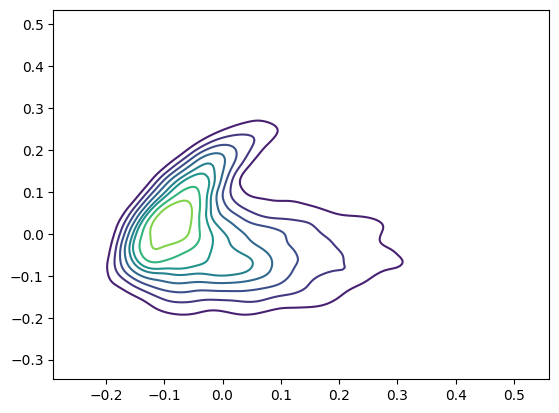

In [25]:
array_pca = pca.transform(array)
kdeplot(x=array_pca[:,0], y=array_pca[:,1], shade=False, cmap="viridis", shade_lowest=True)

In [33]:
print(tSOAP.shape)
print(dtSOAP.shape)

(7, 1760)
(1760, 6)


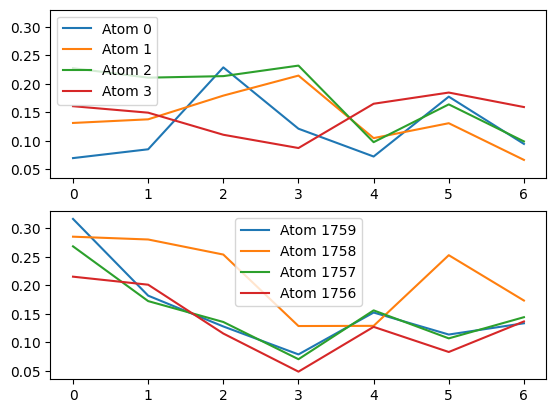

In [34]:
fig, axes = plt.subplots(2, sharey=True)
for i in range(4):
    axes[0].plot(tSOAP[:, i], label=f"Atom {i}")
    axes[1].plot(tSOAP[:, nAtoms - 1 - i], label=f"Atom {nAtoms-1-i}")

for ax in axes:
    ax.legend()

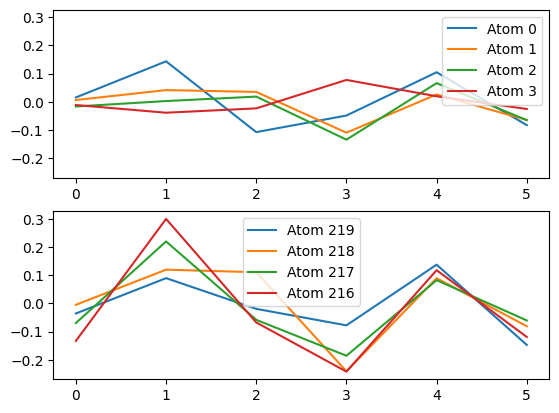

In [30]:
fig, axes = plt.subplots(2, sharey=True)
for i in range(4):
    axes[0].plot(dtSOAP[i], label=f"Atom {i}")
    axes[1].plot(dtSOAP[219 - i], label=f"Atom {219-i}")

for ax in axes:
    ax.legend()

In [ ]:
def signaltonoise(a: np.array, axis, ddof):
    """Given an array, retunrs its signal to noise value of its compontens"""
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return 20 * np.log10(abs(np.where(sd == 0, 0, m / sd)))

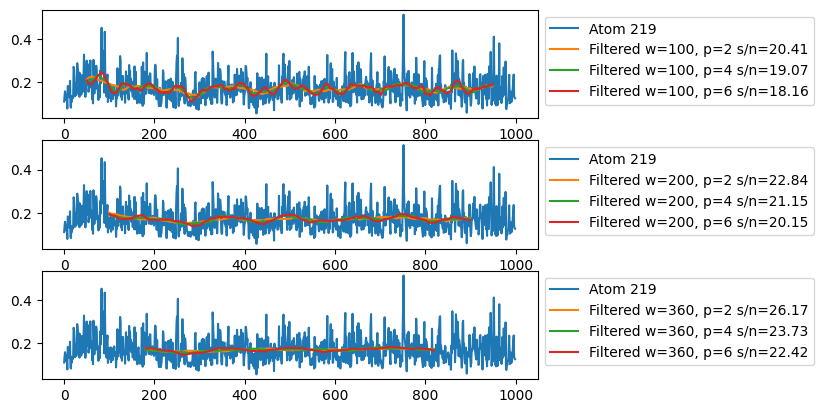

In [ ]:
atom = nAtoms - 1
savGolPrint = np.arange(tSOAP.T[atom].shape[0])
windows = [100, 200, 360]
polyorders = [2, 4, 6]
fig, axes = plt.subplots(len(windows), sharey=True)

for ax, window_length in zip(axes, windows):
    windowToPlot = slice(window_length // 2, -window_length // 2)
    ax.plot(tSOAP.T[atom], label=f"Atom {atom}")
    for polyorder in polyorders:
        savgol = savgol_filter(
            tSOAP.T, window_length=window_length, polyorder=polyorder, axis=-1
        )

        sr_ratio = signaltonoise(savgol[:, windowToPlot], axis=-1, ddof=0)

        ax.plot(
            savGolPrint[windowToPlot],
            savgol[atom, windowToPlot],
            label=f"Filtered w={window_length}, p={polyorder} s/n={np.mean(sr_ratio):.2f}",
        )
    ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

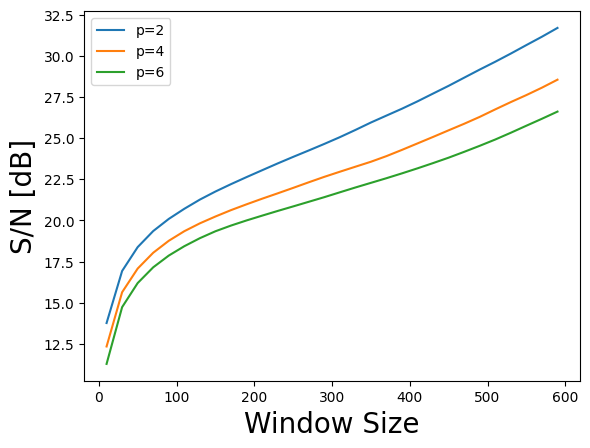

In [ ]:
windows = np.arange(10, 600, 20)
polyorders = [2, 4, 6]
fig, ax = plt.subplots(1)


for polyorder in polyorders:
    meansrRatios = np.empty((len(windows), 2))
    for i, window_length in enumerate(windows):
        windowToPlot = slice(window_length // 2, -window_length // 2)
        savgol = savgol_filter(
            tSOAP.T, window_length=window_length, polyorder=polyorder, axis=-1
        )
        sr_ratio = signaltonoise(savgol[:, windowToPlot], axis=-1, ddof=0)
        meansrRatios[i] = [window_length, np.mean(sr_ratio)]
    ax.plot(meansrRatios[:, 0], meansrRatios[:, 1], label=f"p={polyorder}")
ax.set_xlabel("Window Size", fontsize=20)
ax.set_ylabel("S/N [dB]", fontsize=20)

_ = ax.legend()

In [ ]:
window_length = 360
polyorder = 2
windowToUSE = slice(window_length // 2, -window_length // 2)
filteredtSOAP = savgol_filter(
    tSOAP.T, window_length=window_length, polyorder=polyorder, axis=-1
)

In [ ]:
bestnclusters = 5
clusters = KMeans(bestnclusters, random_state=12345).fit_predict(
    filteredtSOAP.reshape(-1, 1)
)
data_KM = {}
for i in range(bestnclusters):
    data_KM[i] = {}
    data_KM[i]["elements"] = filteredtSOAP.reshape((-1))[clusters == i]
    data_KM[i]["min"] = np.min(data_KM[i]["elements"])
    data_KM[i]["max"] = np.max(data_KM[i]["elements"])

/users_home/makke/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
minmax = [[cname, data["max"]] for cname, data in data_KM.items()]
minmax = sorted(minmax, key=lambda x: x[1])
cmap = ListedColormap([f"C{m[0]}" for m in minmax])
norm = BoundaryNorm([0] + [m[1] for m in minmax], cmap.N)

In [ ]:
def prepareData(x, /):
    """prepares an array from shape (atom,frames) to  (frames,atom)"""
    shape = x.shape
    toret = np.empty((shape[1], shape[0]), dtype=x.dtype)
    for i, atomvalues in enumerate(x):
        toret[:, i] = atomvalues
    return toret


# classyfing by knoing the min/max of the clusters
def classifying(x, classDict):
    toret = np.ones_like(x, dtype=int) * (len(classDict) - 1)
    # todo: sort  by max and then classify
    minmax = [[cname, data["max"]] for cname, data in data_KM.items()]
    minmax = sorted(minmax, key=lambda x: -x[1])
    # print(minmax)
    for cname, myMax in minmax:
        toret[x < myMax] = int(cname)
    return toret


classifiedFilteredtSOAP = classifying(filteredtSOAP, data_KM)


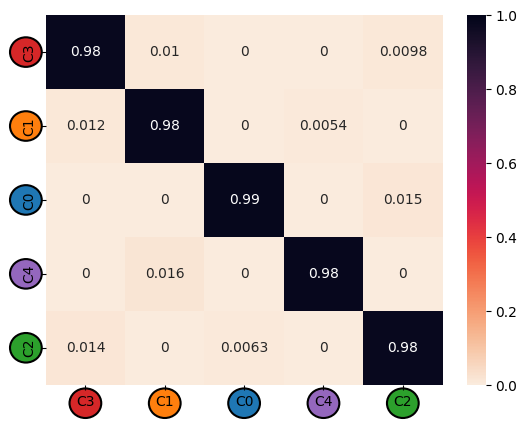

In [ ]:
from SOAPify import SOAPclassification, calculateTransitionMatrix, normalizeMatrixByRow
from seaborn import heatmap

classifications = SOAPclassification(
    [], prepareData(classifiedFilteredtSOAP), [f"C{m[0]}" for m in minmax]
)
tmat = calculateTransitionMatrix(classifications)
tmat = normalizeMatrixByRow(tmat)
_, ax = plt.subplots(1)
heatmap(
    tmat,
    vmax=1,
    vmin=0,
    cmap="rocket_r",
    annot=True,
    xticklabels=classifications.legend,
    yticklabels=classifications.legend,
    ax=ax,
)

for i, label in enumerate(classifications.legend):
    ax.add_patch(
        Circle(
            (0.5 + i, len(classifications.legend) + 0.25),
            facecolor=label,
            lw=1.5,
            edgecolor="black",
            radius=0.2,
            clip_on=False,
        )
    )
    ax.add_patch(
        Circle(
            (-0.25, 0.5 + i),
            facecolor=label,
            lw=1.5,
            edgecolor="black",
            radius=0.2,
            clip_on=False,
        )
    )